In [1]:
import jax.numpy as jnp
import jax
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

from path_sampling import make_double_well_potential, sample_sde
# from spde import refine_spde



In [23]:
from spde import make_discrete_laplacian

J = lambda xts, grad_V, dt: jnp.sum(-dt*jax.vmap(lambda xt: 0.25*grad_V(xt).dot(grad_V(xt)) - 0.5*jnp.trace(jax.jacfwd(lambda k: grad_V(k))(xt)) )(xts))

def pi(xts, grad_V, s, hyperparams):
    dt = hyperparams['dt']
    A = make_discrete_laplacian(hyperparams['num_steps'], dt)
    part1 = s*J(xts, grad_V, dt)
    part2 = jnp.sum(0.25*dt*jax.vmap(lambda xt: xt @ A @ xt , in_axes=-1)(xts))
    return part1 + part2


def step(xts, potential, s, ds, A, key, hyperparams, mh=False, prior= 'brownian'):

    grad_V = lambda x: jax.grad(potential)(x)

    u = lambda x: -s*grad_V(x)

    dt = hyperparams['dt']
    discrete_laplacian = make_discrete_laplacian(hyperparams['num_steps'], dt)

    I = jnp.eye(hyperparams['num_steps'])
    L = (I - 0.25*ds*discrete_laplacian)
    R = (I + 0.25*ds*discrete_laplacian)
    L_inv = jnp.linalg.inv(L)

    jacobian_u = jax.jacfwd(u)

    M_part_1 = -0.5*ds*jax.vmap(lambda k: jacobian_u(k) @ u(k))(xts)
    M_part_2 = -0.5*ds*jax.vmap(jax.grad(lambda k: jnp.trace(jacobian_u(k))))(xts)

    noise = jnp.sqrt(2 * (ds/dt))*jax.random.normal(key, shape=xts.shape)

    xts_ds = L_inv @ (R @ xts + M_part_1 + M_part_2 + noise)

    
    # brownian bridge prior
    if prior=='brownian':
        xts_ds = xts_ds.at[0].set(-1)
        xts_ds = xts_ds.at[-1].set(1)
    elif prior=='sde_prior':
        sigma = 0.1   
        xts_ds = xts_ds.at[0].set(-1)
        # jax.debug.print("u {u}",u=u(xts_ds[-2]))
        # jax.debug.print("xts_ds {x}", x=(xts_ds[-2], dt, s, (1/0.01**2) , (u(xts_ds[-2]) + ((2.*s)/(0.01**2) )*((1 - xts_ds[-2])) )))
        xts_ds = xts_ds.at[-1].set(xts_ds[-2] + dt*(u(xts_ds[-2]) + ((2.*s)/(sigma**2) )*((1 - xts_ds[-2])) )) #todo: pass in sigma
        # jax.debug.print("xts_ds after {x}", x=xts_ds)

    def q(xts, xts_prime):
        return (-(dt/(4*ds))*jnp.linalg.norm(L@xts_prime - R@xts + (M_part_1 + M_part_2))**2)

    if mh:
        log_W = (pi(xts_ds, grad_V, s, hyperparams)+q(xts_ds, xts)) - (pi(xts, grad_V, s, hyperparams)+q(xts, xts_ds))
        accept_prob = jnp.clip(jnp.exp(log_W), 0., 1.)
        # print(accept_prob, "accept_prob")
        # print(f"pi(xts_ds, grad_V, s, hyperparams): {pi(xts_ds, grad_V, s, hyperparams)}")
        # print(f"pi(xts, grad_V, s, hyperparams): {pi(xts, grad_V, s, hyperparams)}")
        # print(f"q(xts_ds, xts): {q(xts_ds, xts)}")
        # print(f"q(xts, xts_ds): {q(xts, xts_ds)}")
        # raise Exception("stop")
        # print("pi", pi(xts_ds, u, hyperparams))
        accept = jax.random.uniform(key) < accept_prob
        # print(accept, "accept")
        xts_ds = xts_ds*accept + xts*(1-accept)


    A = A - ds*J(xts_ds, grad_V, dt)




    return xts_ds, A

def refine_spde(xts, V, s, A, num_steps, key, ds, hyperparams, mh, prior= 'brownian'):

    # u = lambda x: -s*jax.grad(V)(x)


    for i in range(num_steps):
        key = jax.random.fold_in(key, i)
        xts, A = step(
            xts=xts,
            # u=u,
            potential=V,
            A=A,
            s=s,
            key=key,
            ds=ds,
            hyperparams=hyperparams,
            mh=mh,
            prior=prior
        )

    return xts, A

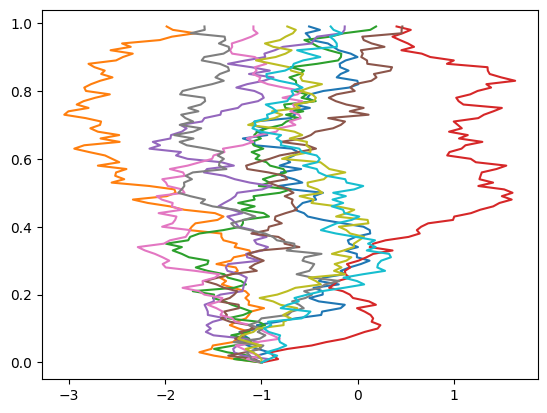

In [24]:

key = jax.random.key(0)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']

ndims = 1

## draw an initial path
# brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)

path_key = jax.random.key(1)
xs, times = jax.pmap(lambda key:sample_sde(
    b=lambda x,t: 0.0, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 10))


## a double well potential
u = lambda x: -jax.grad(make_double_well_potential(v=5.0))(x)

    
xts, A = jax.pmap(lambda key, path: refine_spde(
    xts=path,
    # V=make_double_well_potential(v=5.0),
    V=lambda x: 0.0,
    s=0.0,
    num_steps=100,
    key=key,
    ds=0.01,
    hyperparams=hyperparams,
    A=0,
    mh=False,
    prior='sde_prior'
))(jax.random.split(jax.random.key(0), 10), xs)

# # plot xs[0]
for x in xs:
    plt.plot(x, time, label='sampled')
# plt.plot(xts, time, label='sampled')
# xs[0].shape

# xts



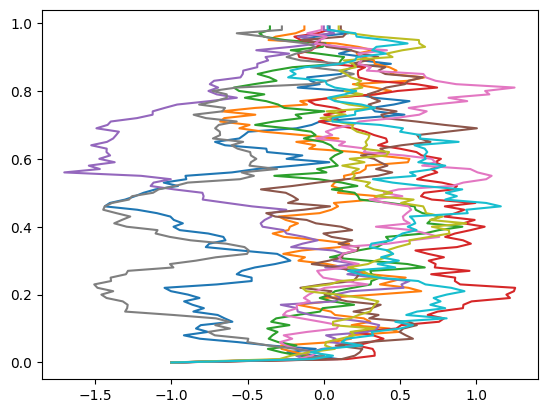

In [25]:
for x in xts:
    plt.plot(x, time, label='sampled')

## Algorithm 2

0.024359507
0.030023683
0.031702634


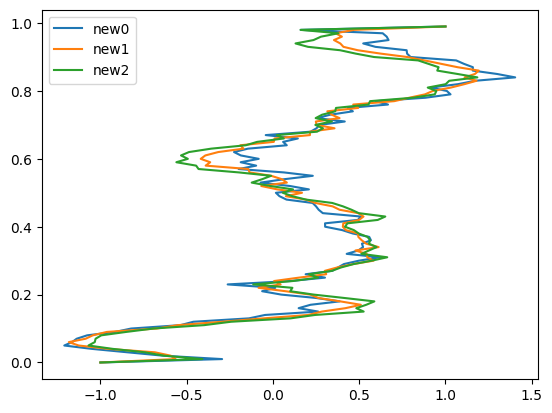

In [21]:
ensemble_size = 10

key = jax.random.key(0)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']

ndims = 1

brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)
path_key = jax.random.key(1)
xts, times = jax.pmap(lambda key:sample_sde(
    b=brownian_bridge_drift, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, ensemble_size))

# for path in xts:
#     # plot
#     plt.plot(path, times[0], label='old', color='black')

A = 0
Z_ratio = 0
schedule = [0.1, 0.5, 1.0]
for i,s in enumerate(schedule):

    xts, A = jax.pmap(lambda k, path: refine_spde(
        xts=path,
        V=make_double_well_potential(v=5.0),
        s=s,
        ds=0.001,
        A=A,
        key=k,
        hyperparams=hyperparams,
        mh=True,
        prior='brownian',
        num_steps=1,
    ))(jax.random.split(jax.random.key(0), ensemble_size), xts)

    plt.plot(xts[0], times[0], label=f'new{i}')

    plt.legend()

    A = (jnp.mean(A))
    Z_ratio += jnp.exp(A)
    print(A)

Z_ratio = Z_ratio/len(schedule)


In [47]:
Z_ratio

Array(2.8163998, dtype=float32)

(100, 2)

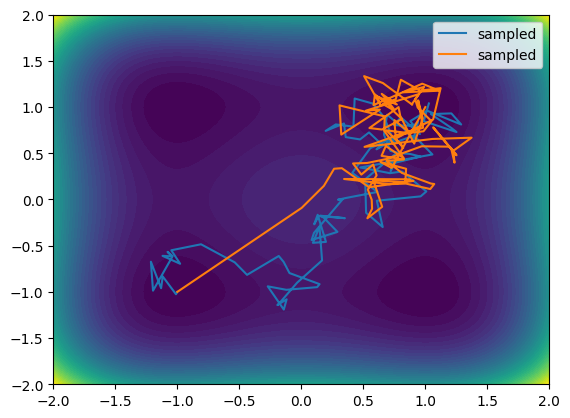

In [ ]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

from path_sampling import make_double_well_potential, plot_path, sample_sde
# from spde import refine_spde

key = jax.random.key(0)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']

ndims = 2

## draw an initial path
brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)
path_key = jax.random.key(2)
xs, times = jax.pmap(lambda key:sample_sde(
    b=brownian_bridge_drift, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


## a double well potential
# u = lambda x: -jax.grad(make_double_well_potential(v=5.0))(x)

    
xts = refine_spde(
    xts=xs[0],
    V=make_double_well_potential(v=5.0),
    s=1.0,
    num_steps=100,
    key=jax.random.key(0),
    ds=0.001,
    hyperparams=hyperparams,
    mh=False
)

# # plot xs[0]
# plt.plot(xs[0], time, label='sampled')
plot_path(xs[0], time, potential=make_double_well_potential(5.0), label='sampled', i=0)
plot_path(xts, time, potential=make_double_well_potential(5.0), label='sampled', i=0)
# plt.plot(xts, time, label='sampled')
xs[0].shape



(100, 1)

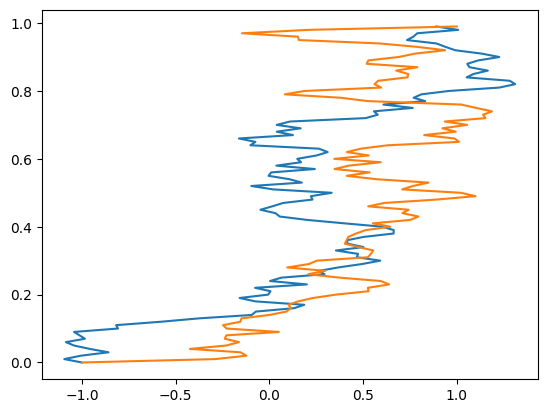

In [ ]:

f = lambda x: (x*((8/((1 + x**2)**2)) - 2))

hyperparams = {'dt': 1e-2, 'num_steps': 1000, 'num_training_steps' : 1000}
ds = hyperparams['dt']**2

brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)
path_key = jax.random.key(1)
xs, times = jax.pmap(lambda key:sample_sde(
    b=brownian_bridge_drift, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt']/10, 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))



xts = spde_integrator(
    xts=xs[0],
    u=f,
    num_steps=1000,
    key=jax.random.key(0),
    ds=0.0001,
    hyperparams=hyperparams
)

plt.plot(xs[0], times[0], label='sampled')
plt.plot(xts, times[0], label='sampled')
